# Lab 4
#### Tanner Kogel tjk190000
##### Mech 6317.001: Dynamics of Complex Networks & Systems

### Import needed libraries

In [259]:
import networkx as nx
from numpy import *
import matplotlib.pyplot as plt
plt.ioff()
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
import asyncio
import random
import randomnet
import math
import numpy

The `randomnet` import statement provides functions to build local attachment and small world random networks. This small world network is slightly different from the version that is implemented in NetowrkX.

## Section 15.1.0: Small World Networks

This function generates a small world network, where `n` nodes are connected to `q` neighboring nodes "around the circle" and with probability `p` to all other nodes. Even though the `randomnet.py` file contains a very similar function, this version has some extra code to lay out the network in an intuitive way (with the nodes in a circle).

In [260]:
async def small_world(n,q,p,G=None,d3=None,x0=300,y0=300):
    '''
    q must be even
    '''
    if d3:
        d3.set_interactive(False)
    if G is None:
        G = D3Graph()
    for i in range(n):
        G.add_node(i)
        if d3:
            x = 200*cos(2*pi*i/n) + x0
            y = 200*sin(2*pi*i/n) + y0
            d3.position_node(i,x,y)
    # add the regular edges
    for u in range(n):
        for v in range(u+1,int(u+1+q/2)):
            v = v % n
            G.add_edge(u,v)

    if d3:
        d3.update()
        await asyncio.sleep(3)
        d3.set_interactive(True)

    # add the random edges
    for u in range(n):
        for v in range(u+1,n):
            if not G.has_edge(u,v):
                if random.random() <= p:
                    G.add_edge(u,v)

    return G

In [261]:
d3 = await d3nx.create_d3nx_visualizer()

websocket server started...visualizer connected...networkx connected...

Now with the visualizer running, we will visualize a small world network

In [262]:
G = D3Graph()
d3.set_graph(G)
G = await small_world(20,4,0.1,G,d3)

with only local connections, the diameter of the graph is 5, and when the random connections added in, the diameter is (probably) 3, and the reason the diameter is so large on the first graph is because it is entirely local, it is similar to the behavior we see in grid-like graph, where there is no small-world effect as the network grows. The lack of overarching connections in the initial graph that connect distant nodes prevents any 'shortcuts' to a distant portion of the graph from arising.

Now let's plot the convergence of the small world effect.

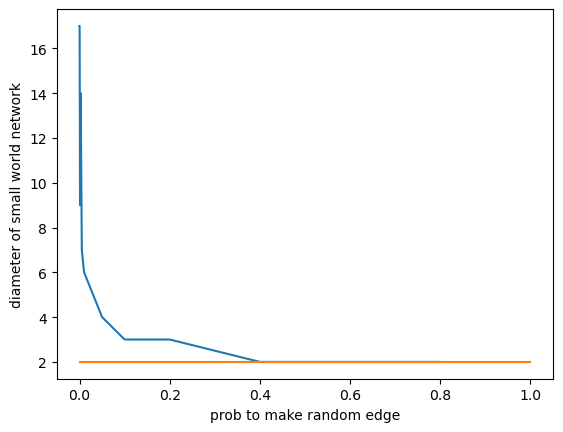

In [264]:
n = 100                                                         # number of nodes
P = [0,0.0001,0.001,0.0025,0.005,0.01,0.05,0.1,0.2,0.4,0.6,0.8] # probability values
d = zeros((len(P),1))                                           # predefine d array
for count, p in enumerate(P):                                   # repeat for each probability
    G = randomnet.small_world_graph(n,6,p)                      # create random network with given probability
    d[count] = nx.diameter(G)                                   # calculate diameter

## Plot the Convergence
plt.figure()
plt.plot(P,d) # change x and y to your "x" and "y" values
plt.plot([0.0001,1],[(log10(n)),(log10(n))])
plt.xlabel('prob to make random edge')
plt.ylabel('diameter of small world network')
plt.show()

If there is no probability for a random edge to be formed, then the network has a very large diameter, with only the 'ring' formation of the small world random graph, but as the probability increases, the number of edges is expected to increase. The increase of the number of edges is expected to decrease the diameter because the small world network initially has connections between 'close' nodes, and the number of random edges makes 'shortcuts' or drastically reduces the shortest path between nodes that are 'distant' in the initial ring graph. Therefore, a greater probability to create a random edge results in a smaller diameter, or the small world effect. The diameter value seems to converge at 2 because the only way for a graph to have a diameter of 1 is if it is a fully connected graph, which is certain for a probability of 1, unlikely for lower probabilities.

## Sections 8.1-8.4.1: Power Law Networks

The following helper functions provide easy access to the degree sequence and the degree and cumulative degree distributions.

In [265]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist

The following function, which you must complete, plots the degree distribution and calculates the power law coefficient, $\alpha$.

In [324]:
def calc_powerlaw(G,kmin=None,follows_scale_law=True,cut_graphs=True):
    ddist = degree_distribution(G,normalize=False) # number of nodes with degree k
    cdist = cumulative_degree_distribution(G)      # fraction of nodes with degree >=k
    k = arange(len(ddist))                         # degree values
    dseq = degree_sequence(G)                      # each node's degree
    if kmin==None:                                 # enforce kmin if none is specified
        kmin = 1                                   # kmin lower bounded by 1

    aggregate = 0                               # initialize 0
    N = cdist[kmin] * G.number_of_nodes()       # number of nodes w/ degree >= k_min
    for k_i in dseq:                            # get aggregate over all nodes
        if k_i < kmin:                          # catch values of k lower than min
            continue                            # do not add to aggregate
        frac = k_i / (kmin - 0.5)               # calculate value inside ln
        aggregate = aggregate + numpy.log(frac) # add ln value (for each node w/ degree k_i)
    alpha = 1 + (N/aggregate)                   # calculate using eq. 8.6
    
    sigma = (alpha - 1) / math.sqrt(N) # calculate using eq. 8.7
    
    if follows_scale_law:
        print( '\talpha = %1.2f +/- %1.2f' % (alpha,sigma) ) # output alpha value with uncertainty
    
    plt.figure(figsize=(8,12))
    plt.subplot(211)
    plt.bar(k,ddist, width=0.8, bottom=0, color='b') # replace xvalues and barheights!
    plt.xlabel('degree (k)')
    plt.ylabel('degree distribution')
    if cut_graphs:
        plt.xlim(left=kmin-0.5)
        plt.ylim(top=1.1*ddist[kmin])

    plt.subplot(212)
    plt.loglog(k,cdist) # replace xvalues and yvalues!
    plt.grid(True)
    plt.xlabel('degree (k)')
    plt.ylabel('cumulative degree distribution')
    if cut_graphs:
        plt.xlim(left=kmin)

## complete & use these functions to plot the degree distribution (bar plot) & cummulative degree distribution (log-log), find a suitable $k_{min}$, and calculate $\alpha$ and the uncertainty $\sigma$

Japanese:
	alpha = 1.61 +/- 0.01
	k_min = 1


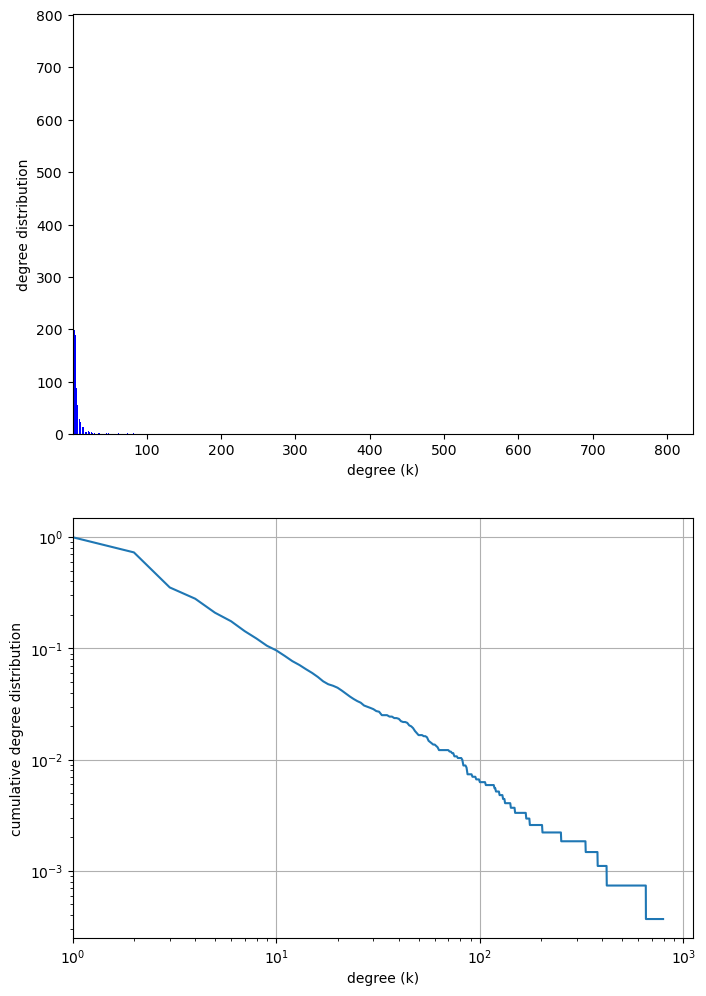

ca-HepTH:
	alpha = 11.31 +/- 3.11
	k_min = 50


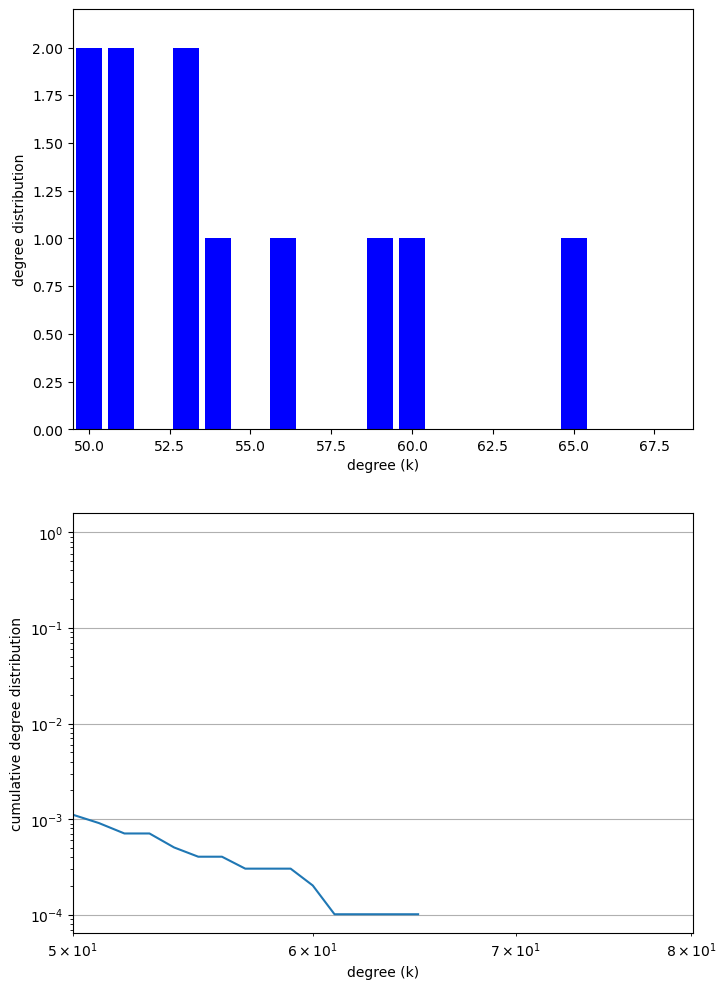

soc-Epinions1:
	alpha = 2.75 +/- 0.05
	k_min = 150


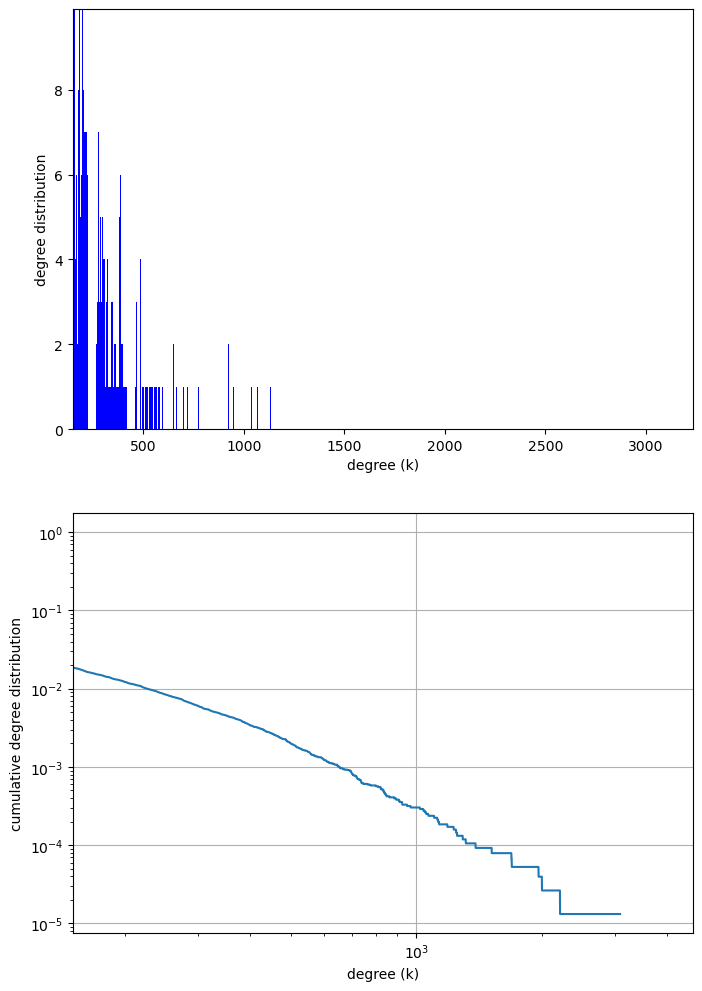

In [328]:
G = nx.read_weighted_edgelist('japanese.edgelist',create_using=nx.DiGraph)
print('Japanese:')
calc_powerlaw(G,1) # select kmin!
print('\tk_min = 1')
plt.show()
G = nx.read_weighted_edgelist('ca-HepTh.edgelist',create_using=nx.Graph)
print('ca-HepTH:')
calc_powerlaw(G,50) # select kmin!
print('\tk_min = 50')
plt.show()
G = nx.read_weighted_edgelist('soc-Epinions1.edgelist',create_using=nx.DiGraph)
print('soc-Epinions1:')
calc_powerlaw(G,150) # select kmin!
print('\tk_min = 150')
plt.show()

## Section 12-12.5: Giant Component

### Recreate right side plot of Newman Figure 12.1 - size of giant component (S) v. average degree (c)

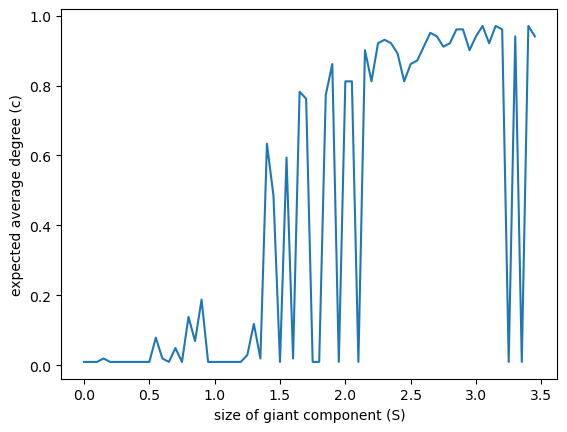

In [334]:
c_list = numpy.arange(0,3.5,0.05)                    # list of average degree values
n = 101                                              # random number of nodes
p_list = c_list / (n-1)                              # eq. 12.6 for probability with expected average degree
S_list = numpy.empty_like(c_list)                    # create numpy array for size of giant component
for count, p in enumerate(p_list):                   # create random graph & get data over the given set
    G = nx.erdos_renyi_graph(n,p)                    # create ER random graph
    giant = max(nx.connected_components(G))          # find giant component
    S_list[count] = len(giant) / G.number_of_nodes() # find size of giant component

# output results to plot
plt.figure()
plt.plot(c_list,S_list)
plt.xlabel('size of giant component (S)')
plt.ylabel('expected average degree (c)')
plt.show()

The behavior we are seeing is representative of the correlation shown in Newman figure 12.1, but there are also drops, where the giant component suddenly does not exist, when it should. Other than this, the error between the expected value and the data is small. The non-monotonic behavior is likely due to the random nature of the creation of the Erdos-Renyi graph. The drops in the graph are likely instances where the network is made up of small components that are highly connected. The likelihood of such graphs being created is smaller than the behavior demonstrated in Newman figure 12.1, but it can skew the results and create the non-monotnic behavior seen above.

## use multiple tests of each probability to get a more stable graph

n = 10


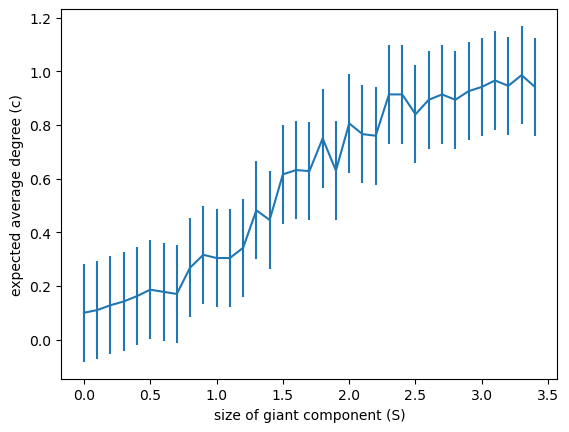

n = 100


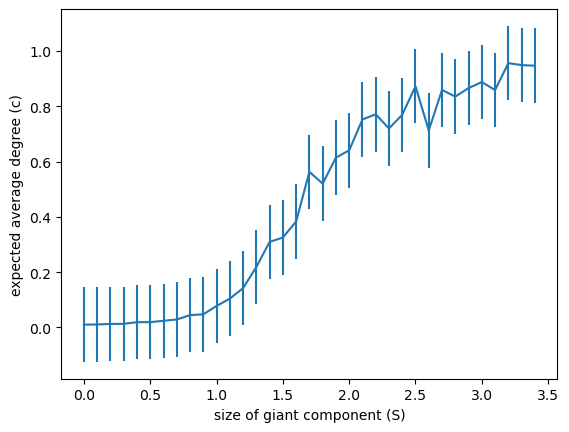

n = 1000


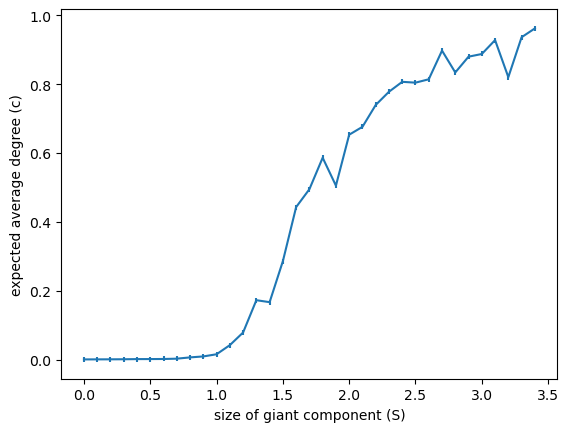

In [338]:
# create function to plot 
def doplot(n):
    c_list = numpy.arange(0,3.5,0.1)                # list of average degree values
    p_list = c_list / (n-1)                         # eq. 12.6 for probability with expected average degree
    S_list = numpy.empty_like(c_list)               # create numpy array for giant component size
    S_std = numpy.empty_like(c_list)                # create numpy array for standard deviation
    num_tests = 50                                  # number of tests
    s = numpy.empty([num_tests,1])                  # initialize test data array
    for count, p in enumerate(p_list):              # loop for each expeced average degree value
        for i in range(num_tests):                  # loop for each test
            G = nx.erdos_renyi_graph(n,p)           # create ER random graph
            giant = max(nx.connected_components(G)) # find giant component
            s[i] = len(giant) / G.number_of_nodes() # find normalized size of giant component
        S_list[count] = numpy.mean(s)               # find size of giant component
        S_std = numpy.std(s)                        # find standard deviation

    # output results to plot
    print('n = %i' % n)
    plt.figure()
    plt.errorbar(c_list,S_list,yerr=S_std)
    plt.xlabel('size of giant component (S)')
    plt.ylabel('expected average degree (c)')
    plt.show()
    
n_list = [10, 100]#, 1000]
for n in n_list:
    doplot(n)

Each iteration of the plots shown above show a decrease in the size of the error bars, as well as a tendency to more closelt follow the behavior describe in Newman fiure 12.1, especially in the region where S < 1.0. This supports the notion that the statistics of the model converge to their expected values as n gets larger because when many graphs are averaged, the behavior shows a trend that as n increases, the behavior of the random graphs more closely exhibits the behavior that is expected and does so more consistently.

## Degree Distributions of Random Network Models

### use the earlier plotting functions to look at the degree distributions & cummulative degree distributions of the random networks discussed in class

#### Erdos-Renyi

Erdos-Renyi: p = 0.001


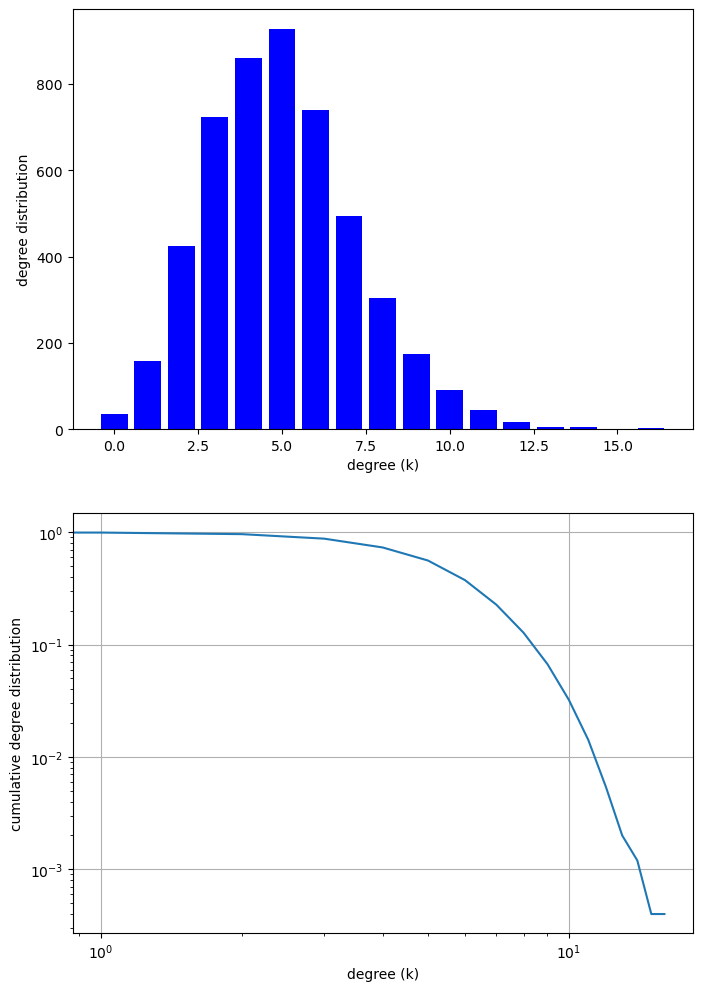

Erdos-Renyi: p = 0.100


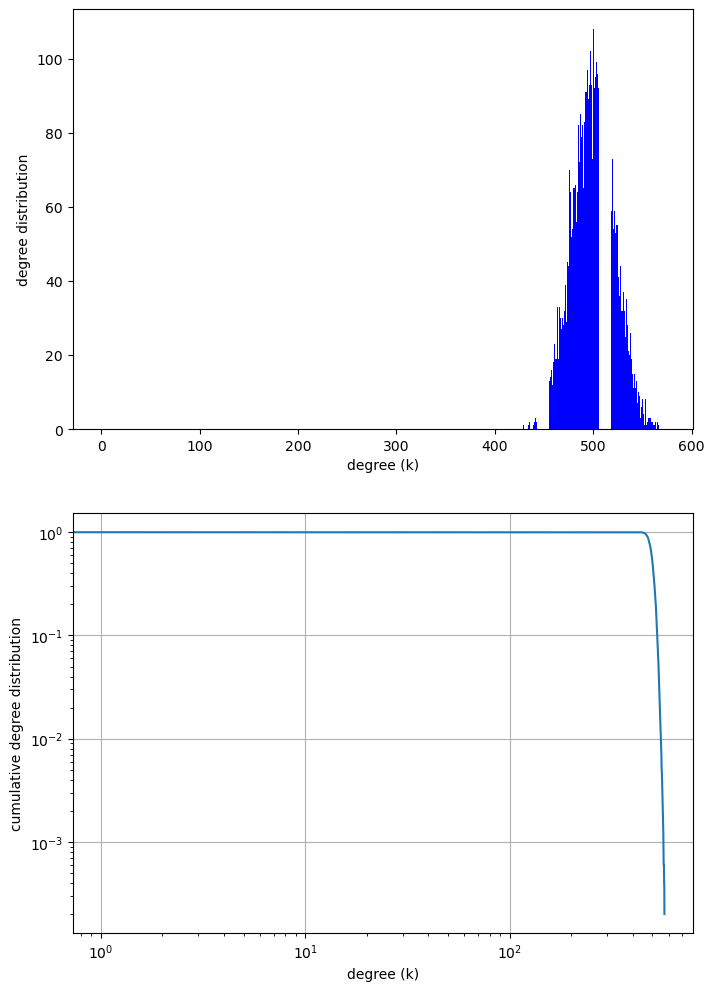

Erdos-Renyi: p = 0.500


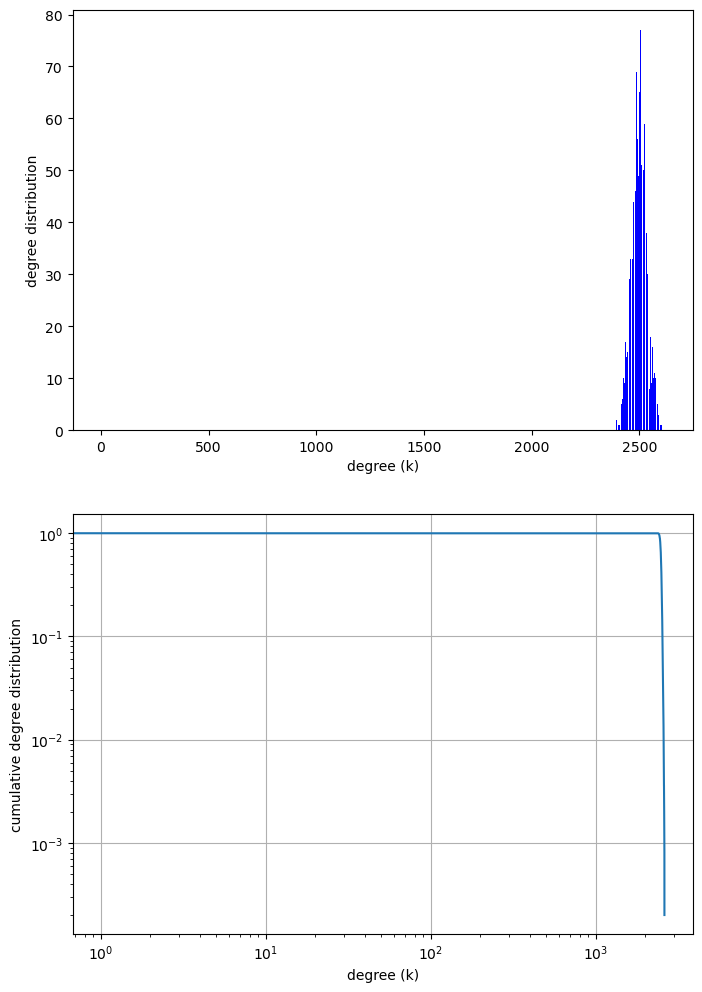

In [340]:
n = 5000                               # set number of nodes
p_list = [0.001,0.1,0.5]               # create different probability values
for p in p_list:                       # loop for every probability
    print('Erdos-Renyi: p = %1.3f' % p) # output graph type and probability value
    G = nx.erdos_renyi_graph(n,p)      # create ER graph
    calc_powerlaw(G,1,False,False)     # use function to calculate values
    plt.show()                         # show plots

#### Small-World

small-world q = 2; p = 0.001


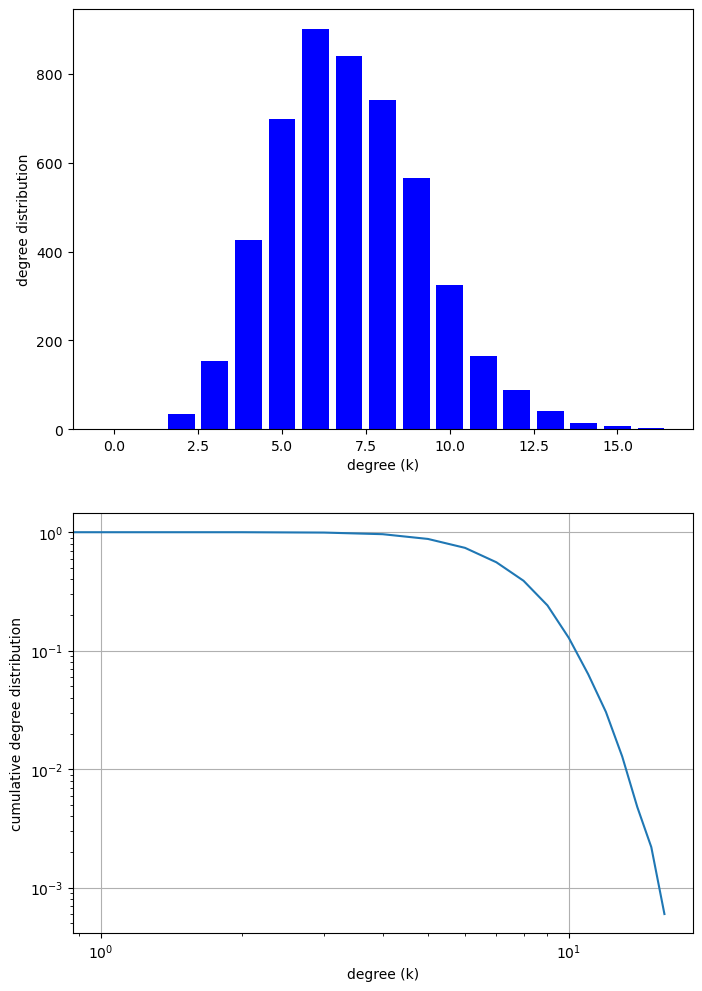

small-world q = 2; p = 0.100


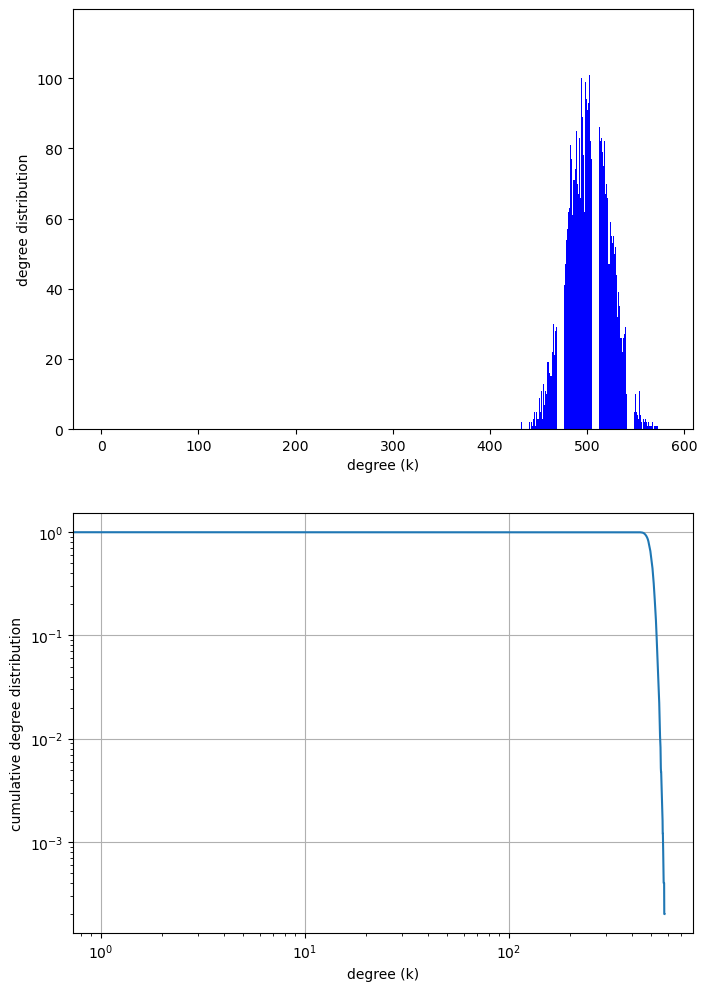

small-world q = 2; p = 0.500


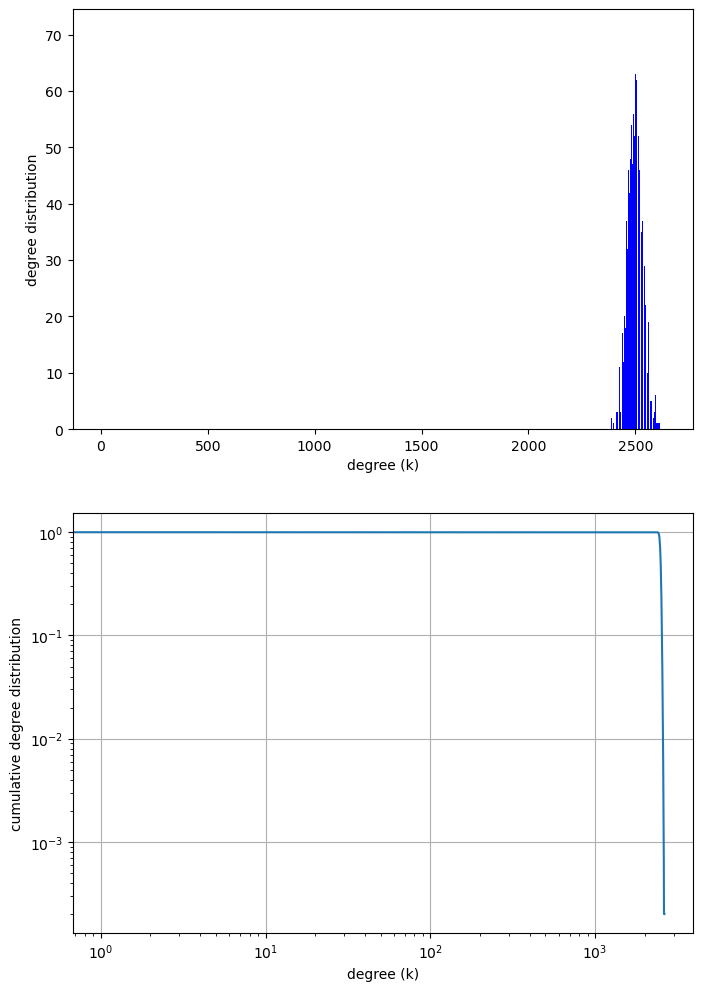

small-world q = 10; p = 0.001


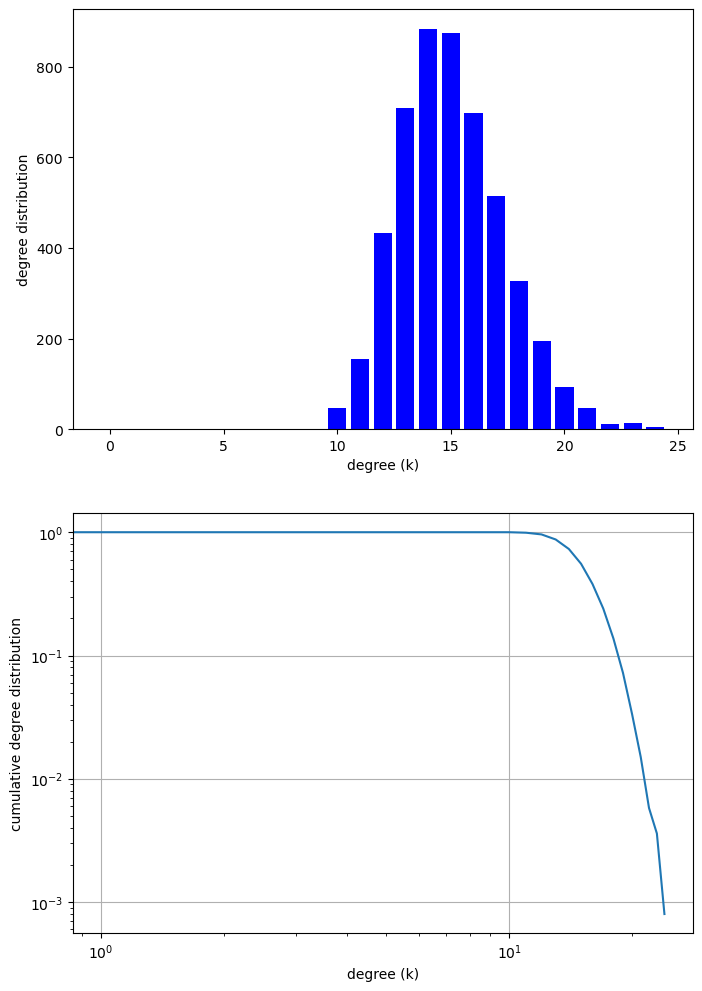

small-world q = 10; p = 0.100


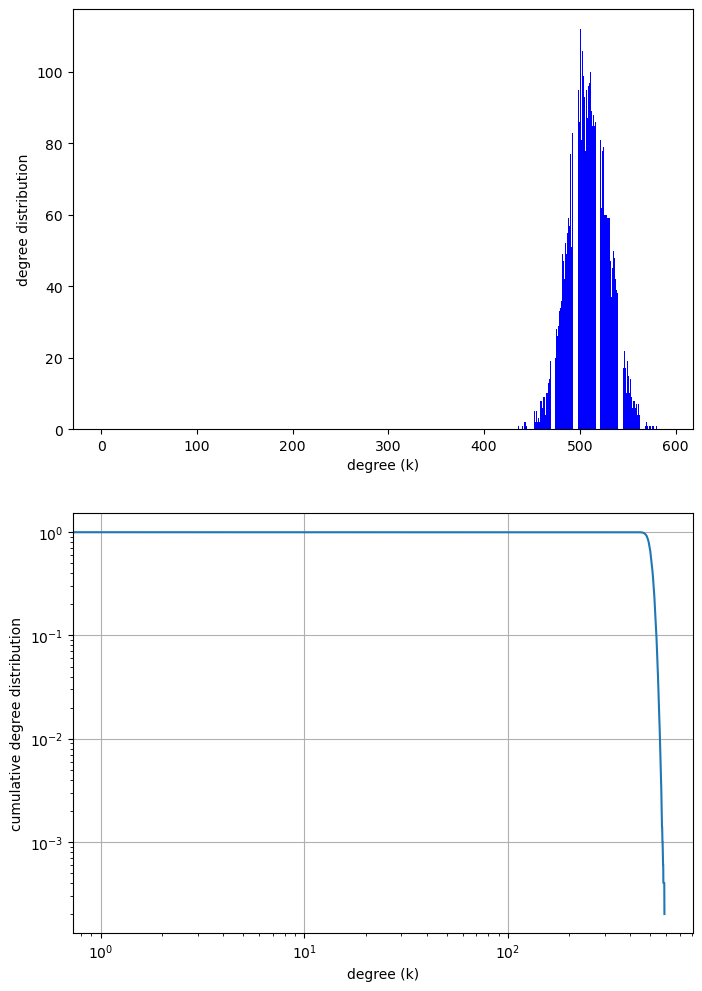

small-world q = 10; p = 0.500


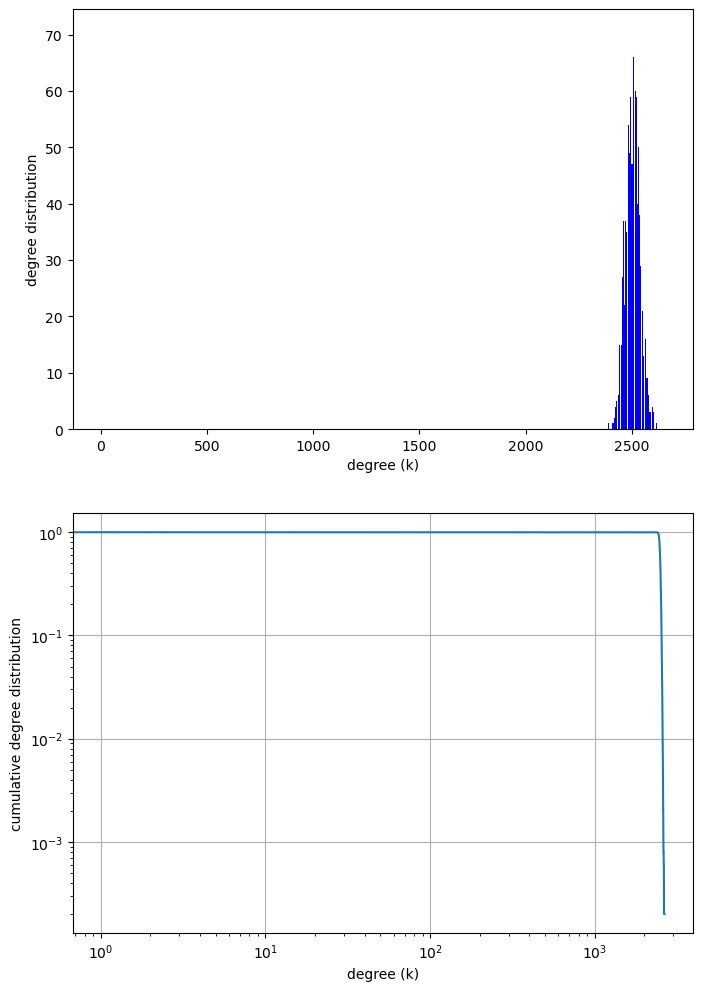

small-world q = 100; p = 0.001


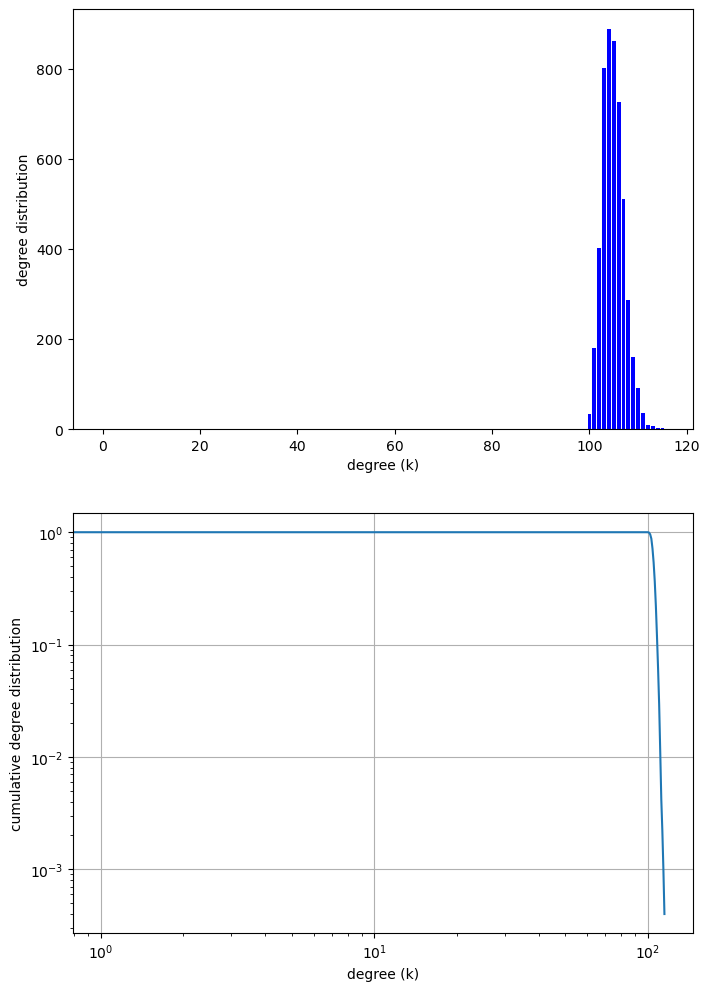

small-world q = 100; p = 0.100


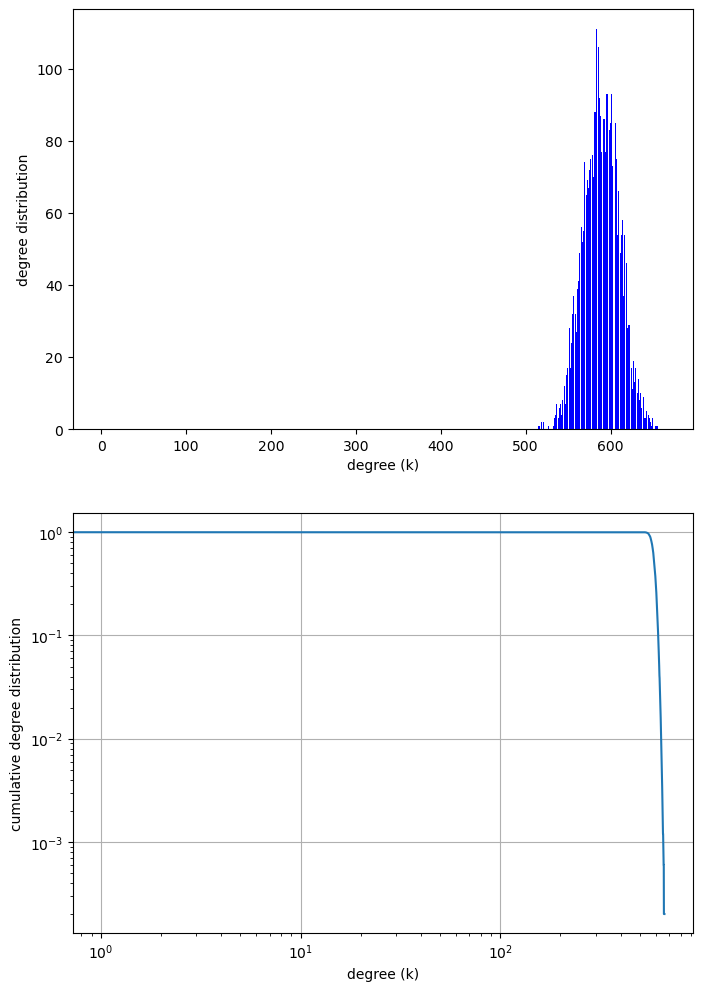

small-world q = 100; p = 0.500


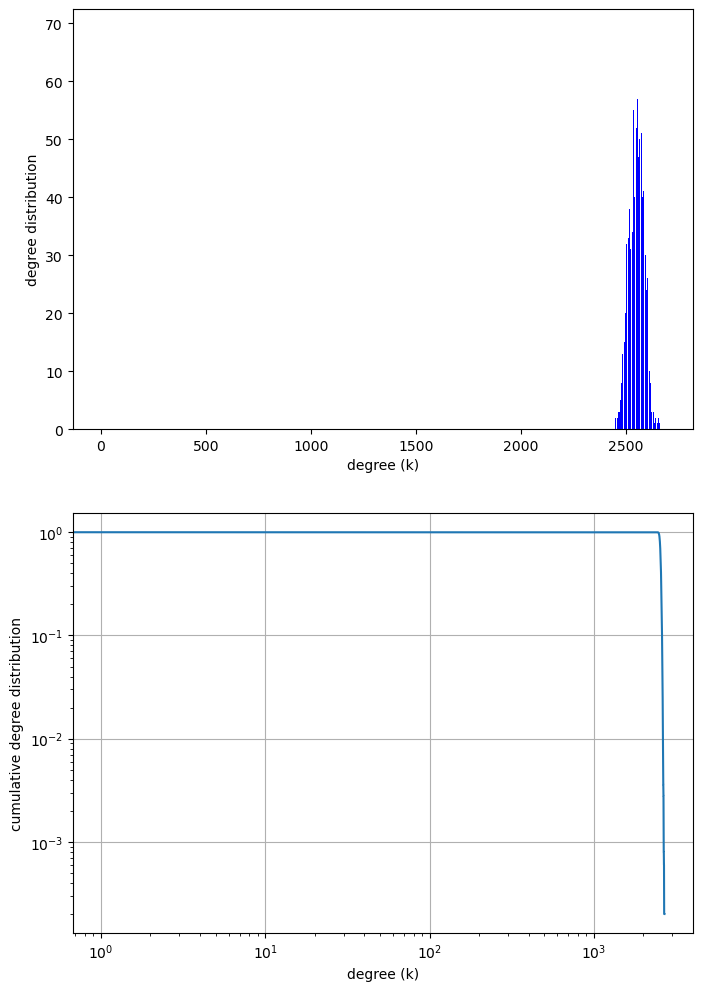

In [342]:
q_list = [2,10,100]                                    # create list of q values
for q in q_list:                                       # loop for every q value
    for p in p_list:                                   # loop for every probability value
        print('small-world q = %i; p = %1.3f' % (q,p)) # output graph type and parameters
        G = randomnet.small_world_graph(n,q,p)         # create sm graph
        calc_powerlaw(G,1,False,False)                 # use function to calculate values
        plt.show()                                     # show plots

### Barabasi-Albert

Barabasi-Albert m = 10
	alpha = 2.85 +/- 0.03


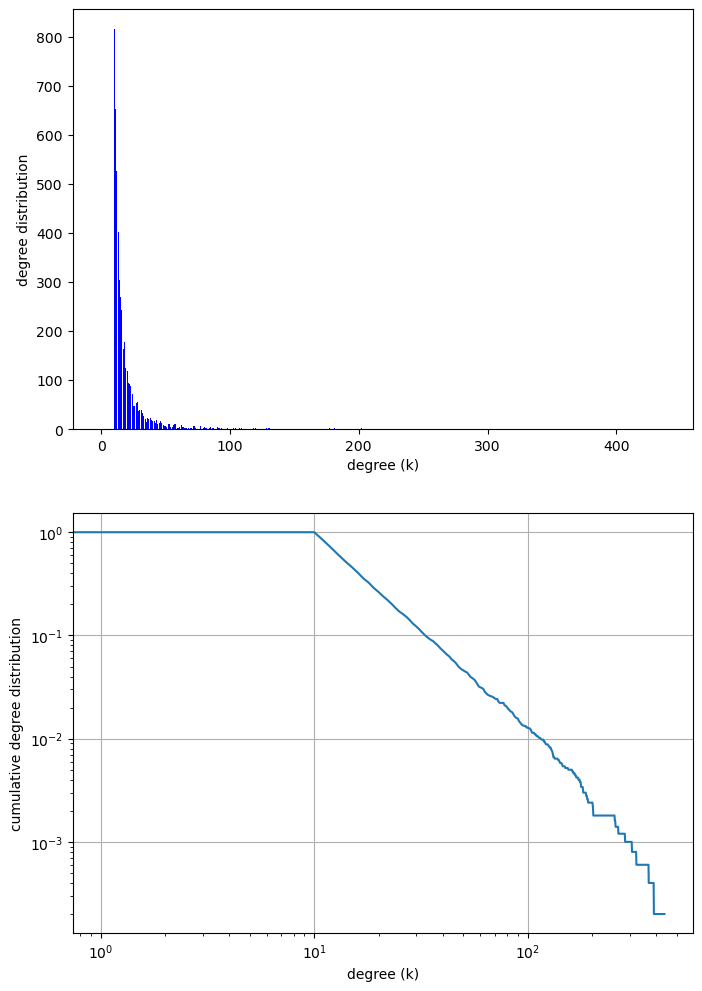

Barabasi-Albert m = 100
	alpha = 2.91 +/- 0.03


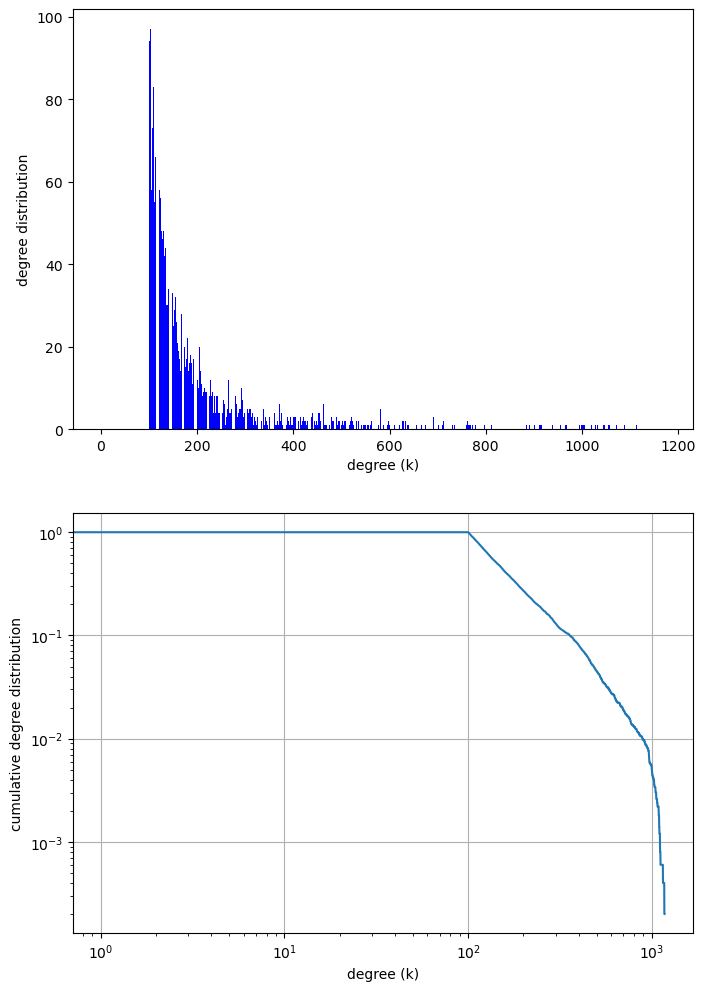

Barabasi-Albert m = 1000
	alpha = 3.43 +/- 0.03


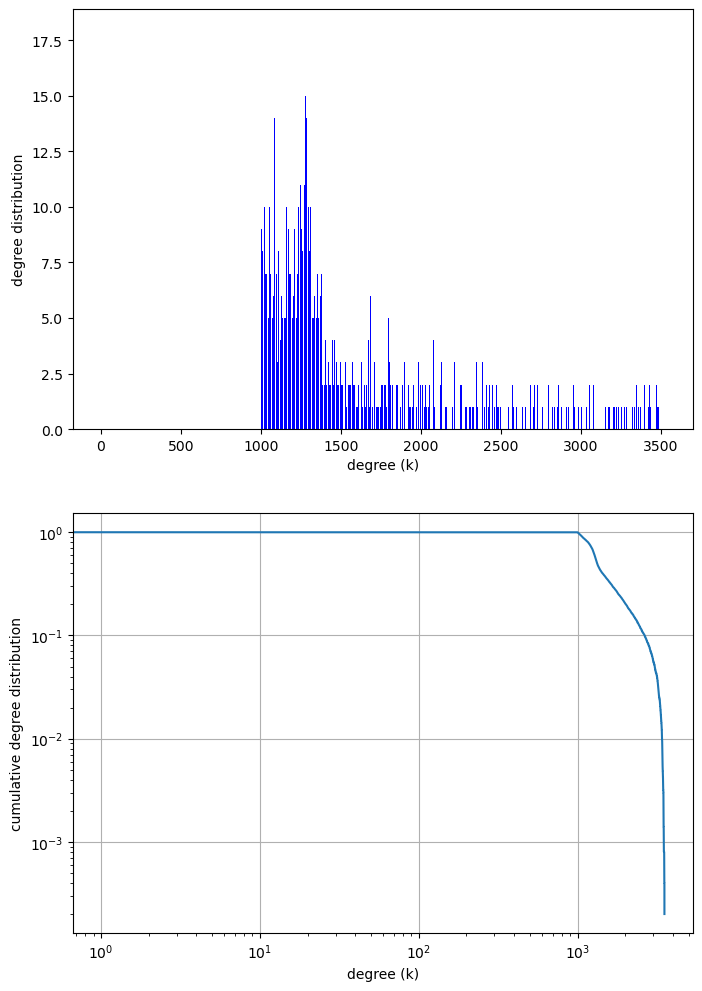

In [343]:
m_list = [10,100,1000]                  # create different probability values
for m in m_list:                        # loop for every probability
    print('Barabasi-Albert m = %i' % m) # output graph type and probability value
    G = nx.barabasi_albert_graph(n,m)   # create BA graph
    calc_powerlaw(G,m,cut_graphs=False) # use function to calculate values
    plt.show()                          # show plots

### Local Attachment

Local Attachment m = 2; r = 1
	alpha = 1.55 +/- 0.01


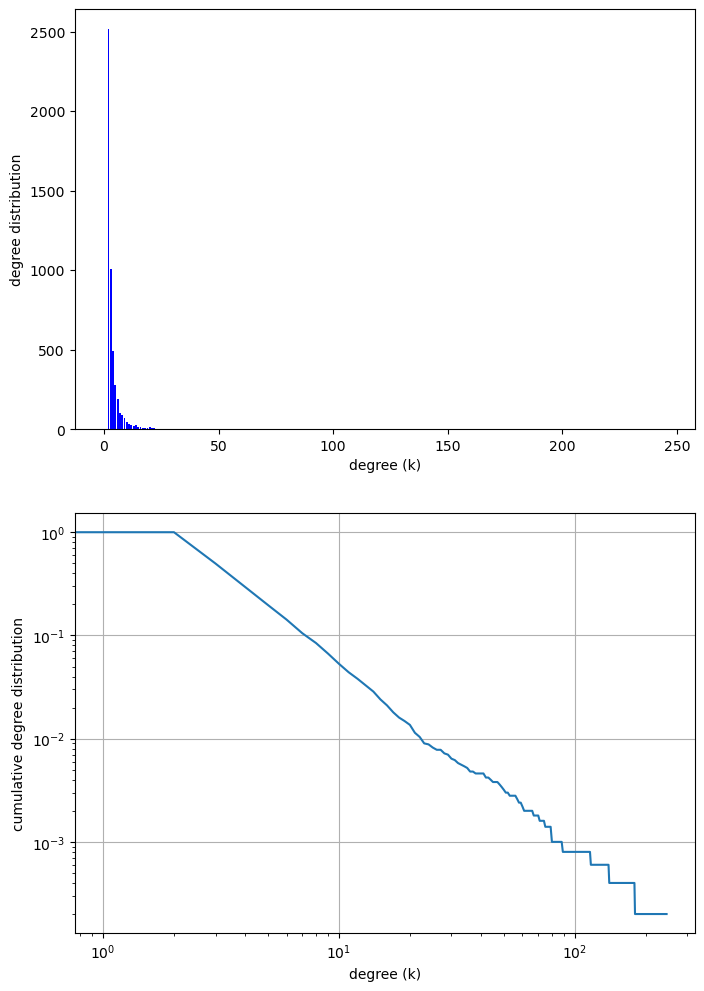

Local Attachment m = 10; r = 1
	alpha = 1.31 +/- 0.00


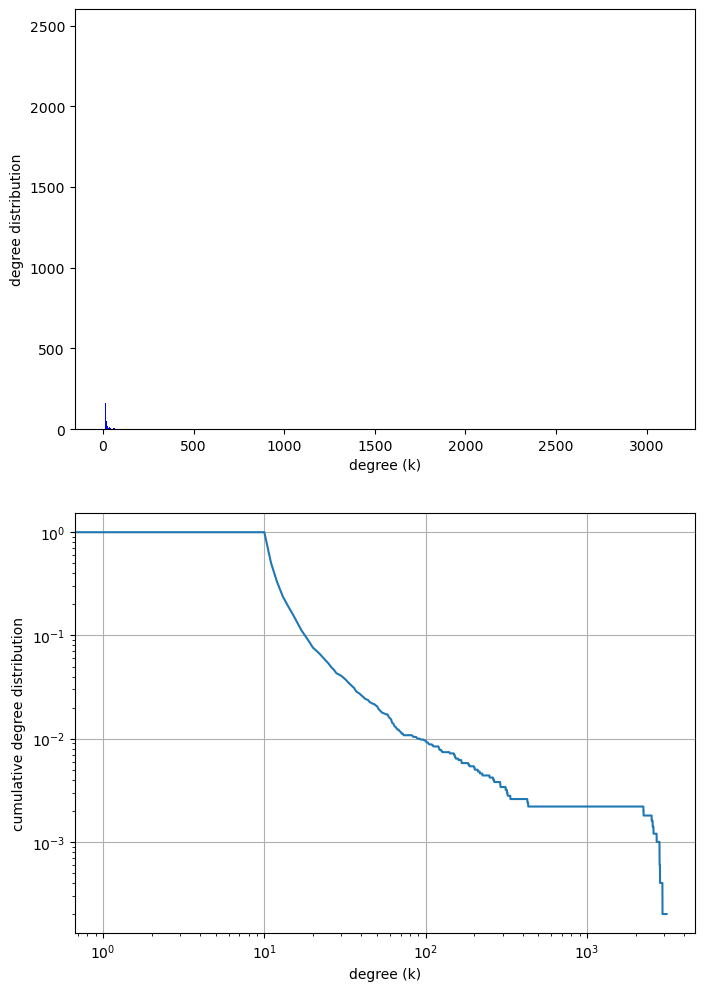

Local Attachment m = 10; r = 5
	alpha = 1.29 +/- 0.00


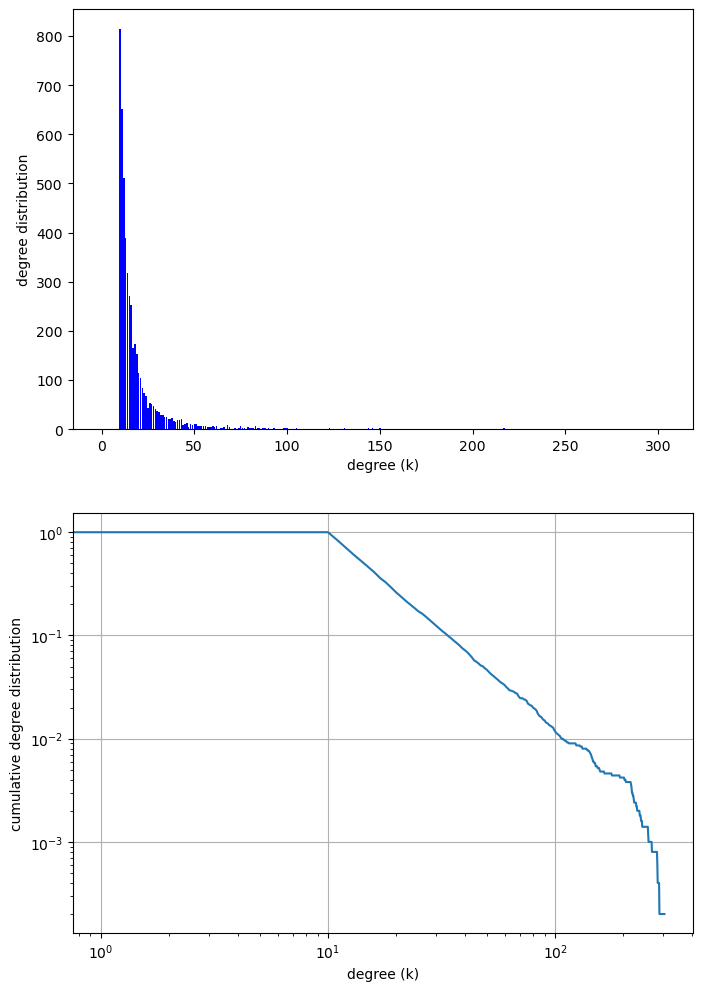

Local Attachment m = 100; r = 1
	alpha = 1.19 +/- 0.00


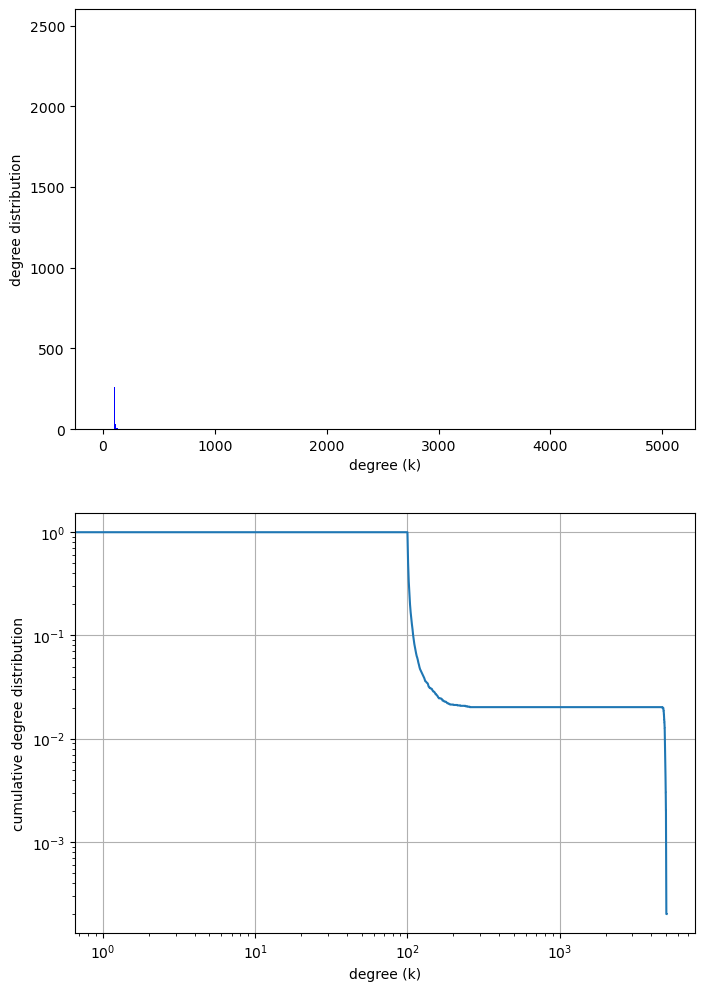

Local Attachment m = 100; r = 5
	alpha = 1.18 +/- 0.00


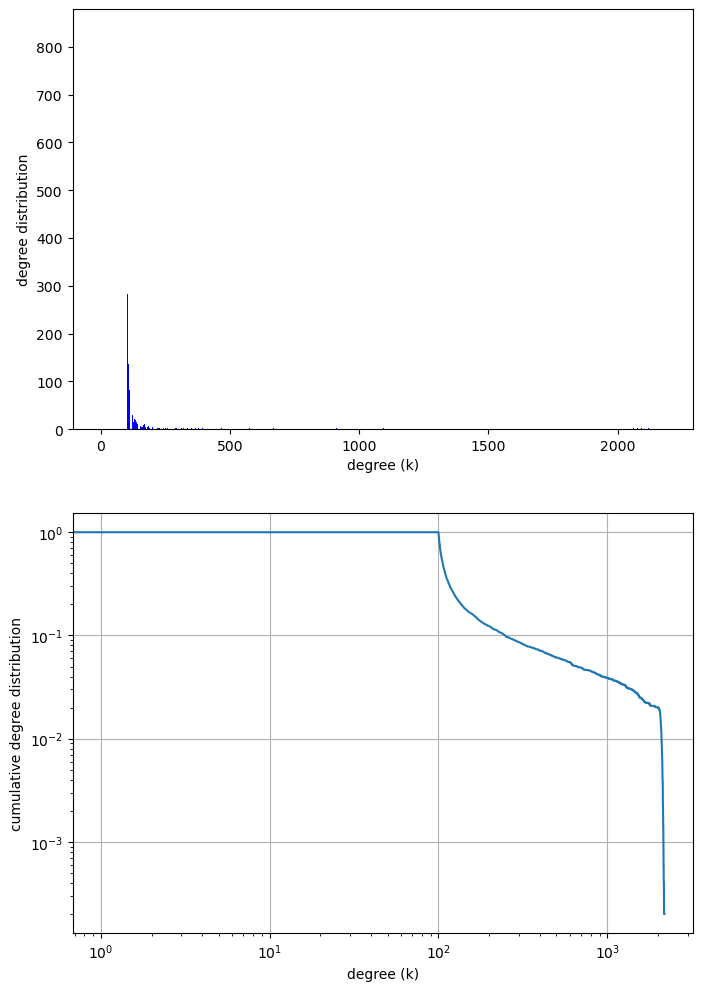

Local Attachment m = 100; r = 95
	alpha = 1.17 +/- 0.00


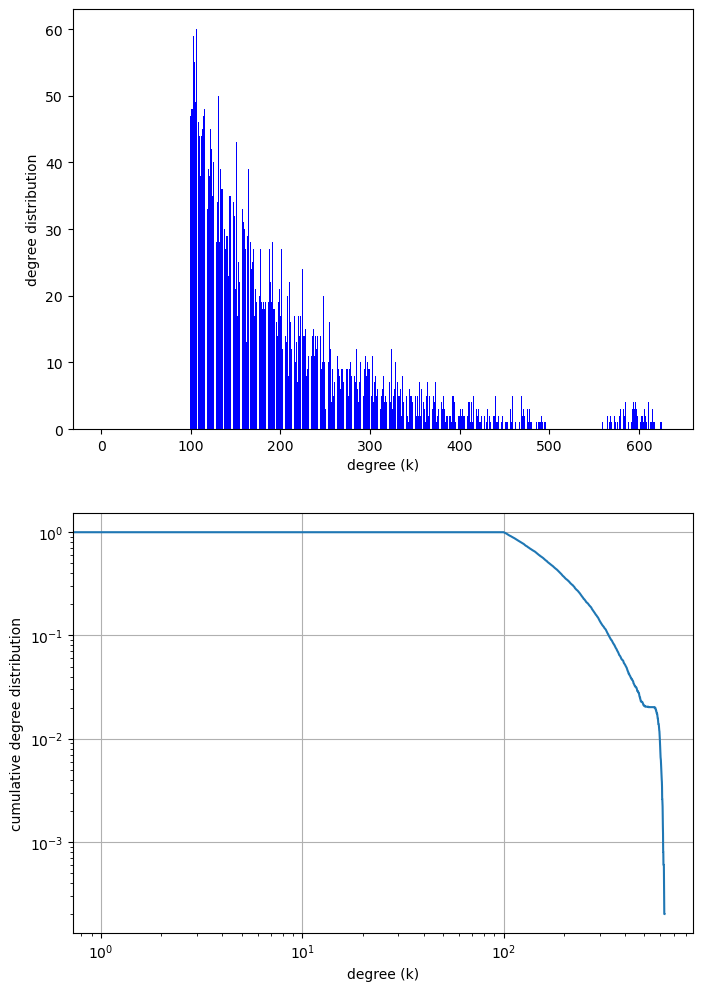

In [344]:
r_list = [1,5,95]                                            # create list of r values
for q in q_list:                                             # loop for every q value
    for r in r_list:                                         # loop for every r value
        if r < q:                                            # only valid models
            print('Local Attachment m = %i; r = %i' % (q,r)) # output graph type and parameters
            G = randomnet.local_attachment_graph(n,q,r)      # create sm graph
            calc_powerlaw(G,1,cut_graphs=False)              # use function to calculate values
            plt.show()                                       # show plots

#### Duplication Divergence

Duplication Divergence p = 0.001
	alpha = 1.94 +/- 0.01


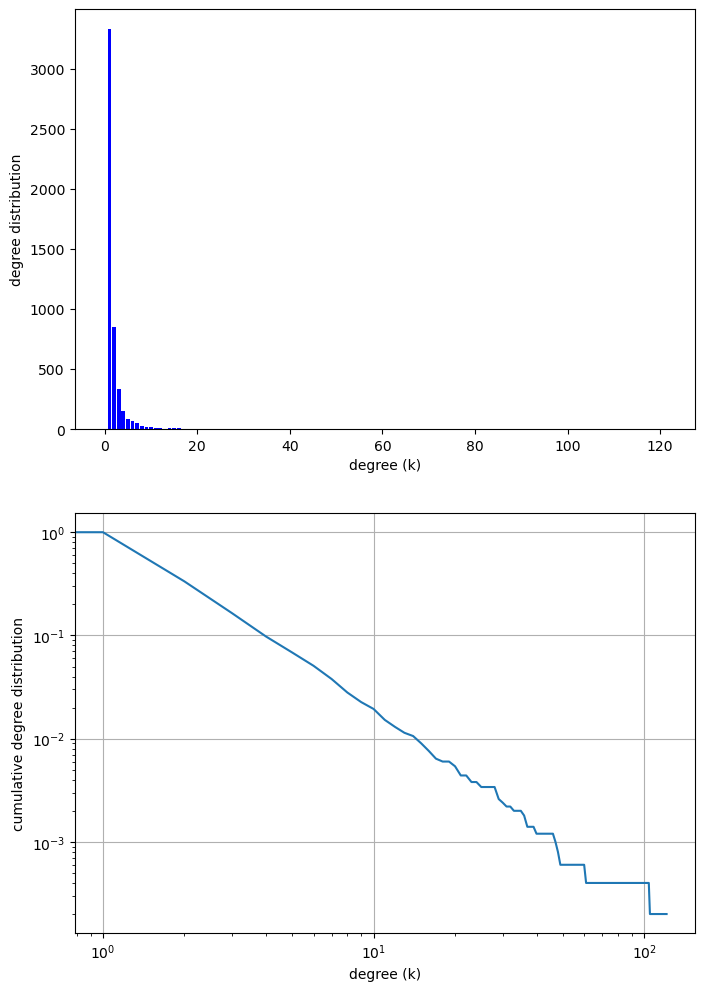

Duplication Divergence p = 0.100
	alpha = 1.81 +/- 0.01


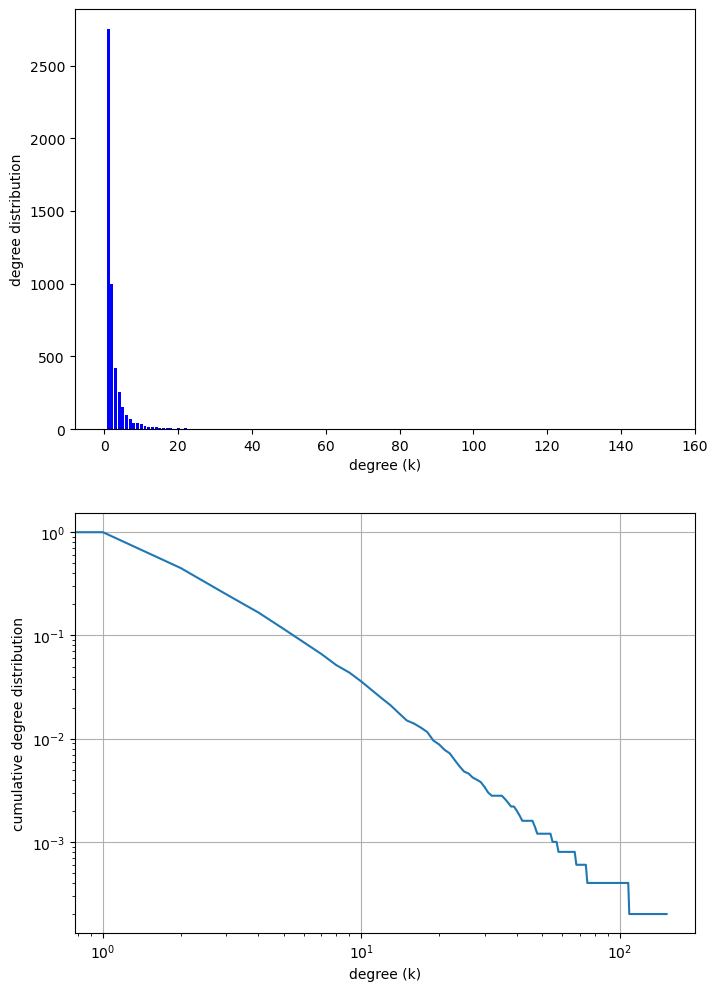

Duplication Divergence p = 0.500
	alpha = 1.43 +/- 0.01


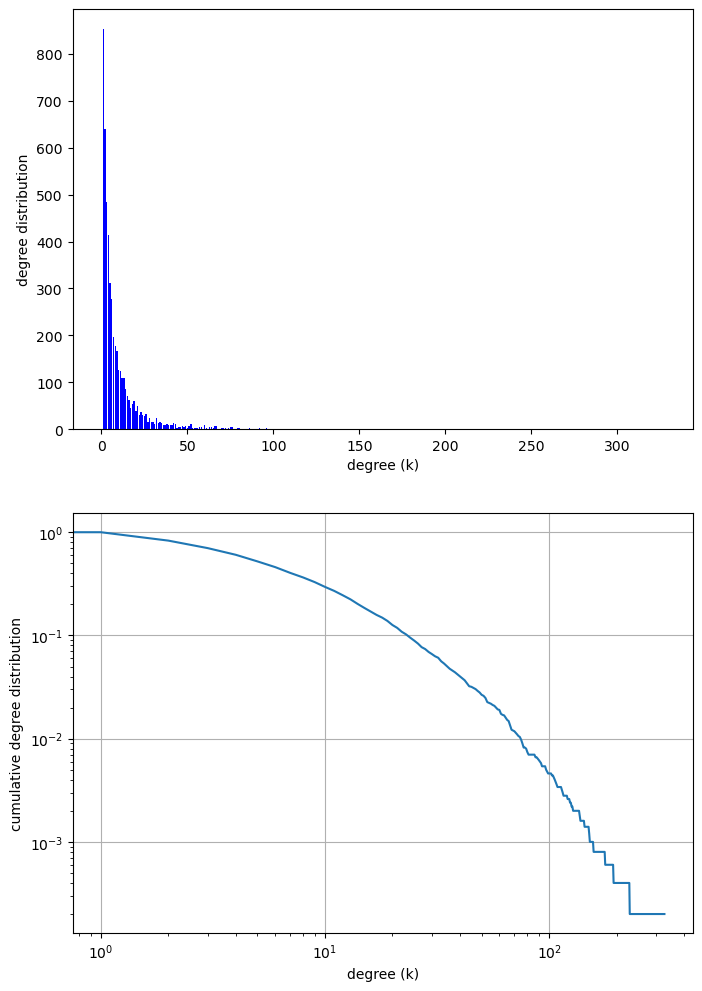

In [345]:
for p in p_list:                                  # loop for every probability
    print('Duplication Divergence p = %1.3f' % p) # output graph type and probability value
    G = nx.duplication_divergence_graph(n,p)      # create ER graph
    calc_powerlaw(G,1,cut_graphs=False)           # use function to calculate values
    plt.show()                                    # show plots

## Fitting Random Models

### Present actual statistics of co-Hep network

ca-Hep network:
	n: 9877
	m: 25998
	average clustering: 0.4714
	alpha = 11.31 +/- 3.11


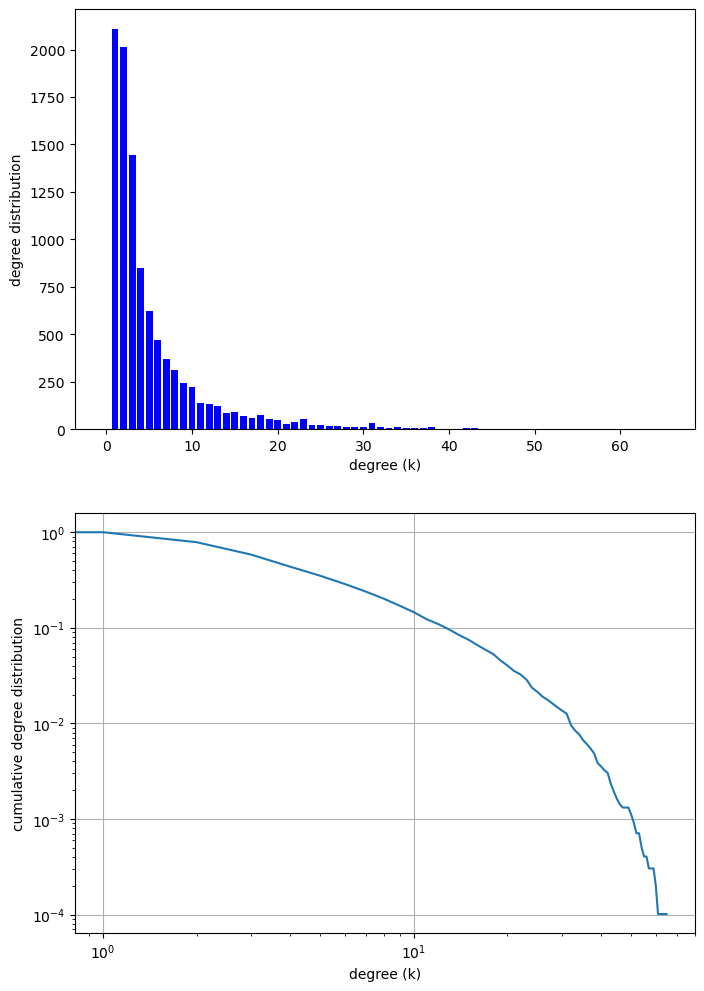

In [346]:
G = nx.read_weighted_edgelist('ca-HepTh.edgelist')     # read network data
n = G.number_of_nodes()                                # find num nodes (n)
m = G.number_of_edges()                                # find num edges (m)
avg_clustering = nx.average_clustering(G)              # find average clustering
print('ca-Hep network:')                               # label network
print('\tn: %i' % n)                                   # output num nodes (n)
print('\tm: %i' % m)                                   # output num edges (m) 
print('\taverage clustering: %1.4f' % avg_clustering)  # output average clustering
calc_powerlaw(G,50,cut_graphs=False)                   # calculate power law
plt.show()                                             # show plots

### Erdos-Renyi graph as similar to ca-Hep network as possible

Erdos-Renyi Graph:
	n: 9877
	m: 25846
	average clustering: 0.0006
	alpha = 9.16 +/- 0.41


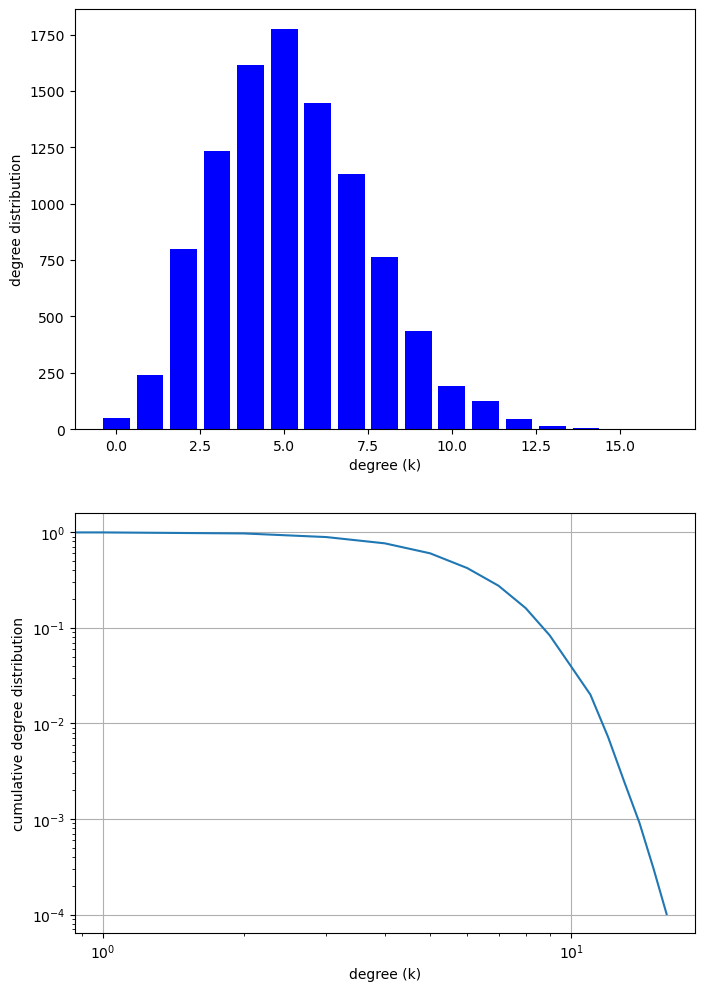

In [368]:
p = 2*m/n/(n-1)                                       # find probabilty to give roughly same number of edges
G = nx.erdos_renyi_graph(n,p)                         # create random graph using this probabilty
n = G.number_of_nodes()                               # find num nodes (n)
m = G.number_of_edges()                               # find num edges (m)
avg_clustering = nx.average_clustering(G)             # find average clustering
print('Erdos-Renyi Graph:')                           # label network
print('\tn: %i' % n)                                  # output num nodes (n)
print('\tm: %i' % m)                                  # output num edges (m)
print('\taverage clustering: %1.4f' % avg_clustering) # output average clustering
calc_powerlaw(G,10,cut_graphs=False)                  # calculate power law
plt.show()                                            # show plots

### Local Attachment graph as similar to ca-Hep network as possible

Local Attachment Graph:
	n: 9877
	m: 29631
	average clustering: 0.4111
	alpha = 1.46 +/- 0.00


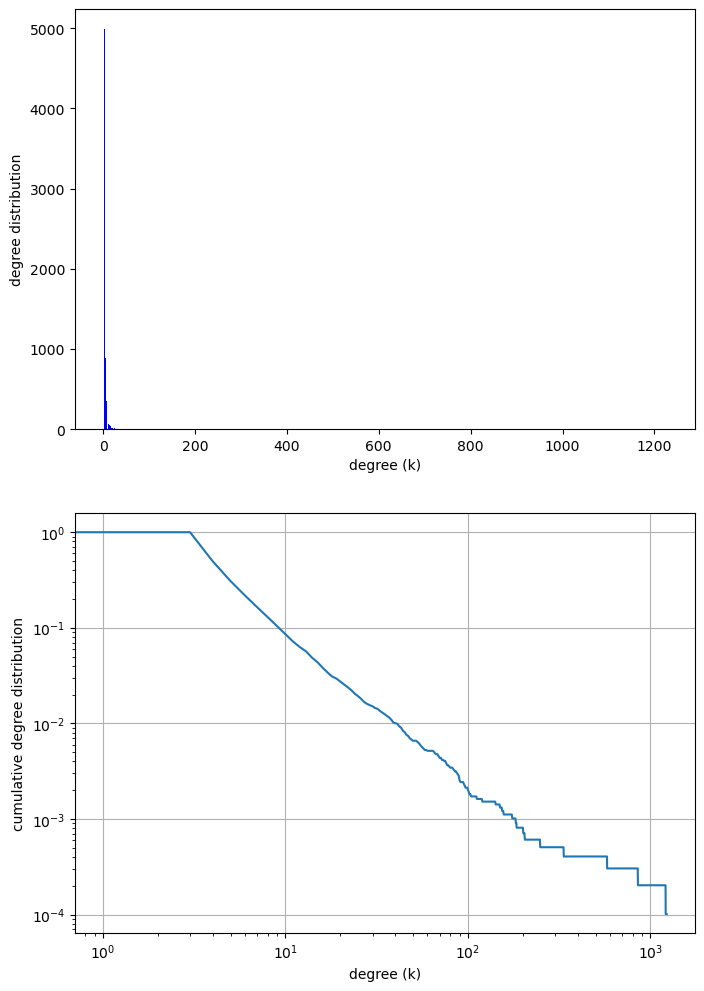

In [369]:
# find q & r values that get the graph close to the original
q = 3
r = 1
G = randomnet.local_attachment_graph(n,q,r)           # create random graph using values
n = G.number_of_nodes()                               # find num nodes (n)
m = G.number_of_edges()                               # find num edges (m)
avg_clustering = nx.average_clustering(G)             # find average clustering
print('Local Attachment Graph:')                      # label graph
print('\tn: %i' % n)                                  # output num nodes (n)
print('\tm: %i' % m)                                  # output num edges (m)
print('\taverage clustering: %1.4f' % avg_clustering) # output average clustering
calc_powerlaw(G,1,cut_graphs=False)                   # calculate power law
plt.show()                                            # show plots

### Duplication Divergence graph as similar to ca-Hep network as possible

Duplication Divergence Graph:
	n: 9877
	m: 24269
	average clustering: 0.0000
	alpha = 3.36 +/- 0.71


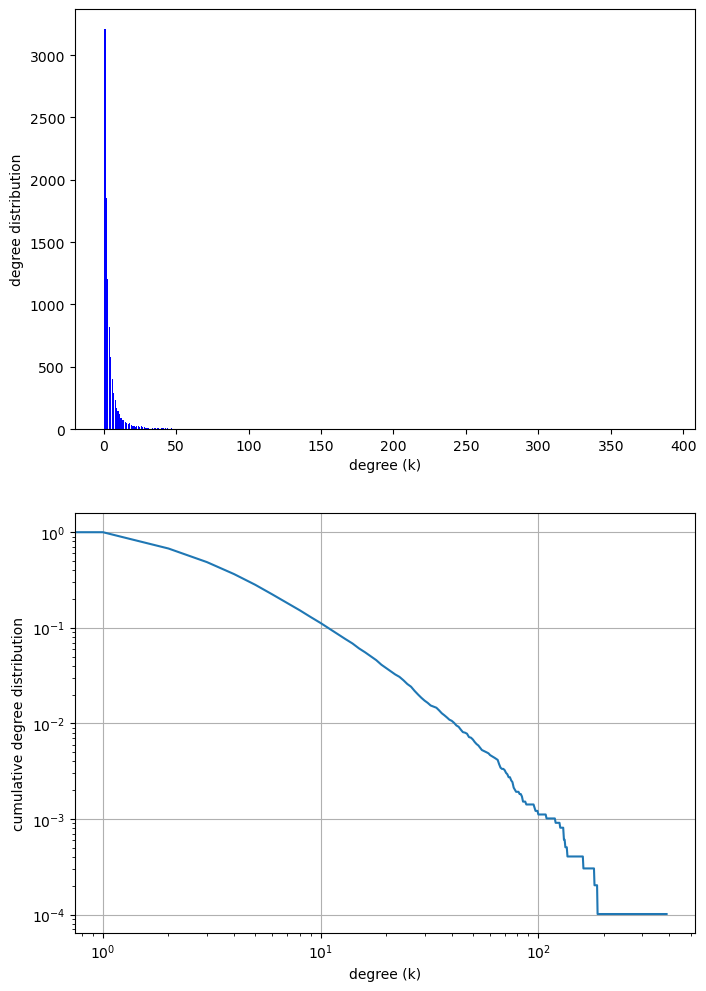

In [370]:
# find probabilty value that gets the graph close to the original
p = 0.345
G = nx.duplication_divergence_graph(n,p)              # create random graph using probabilty value
n = G.number_of_nodes()                               # find num nodes (n)
m = G.number_of_edges()                               # find num edges (m)
avg_clustering = nx.average_clustering(G)             # find average clustering
print('Duplication Divergence Graph:')                # label graph
print('\tn: %i' % n)                                  # output num nodes (n)
print('\tm: %i' % m)                                  # output num edges (m)
print('\taverage clustering: %1.4f' % avg_clustering) # output average clustering
calc_powerlaw(G,100,cut_graphs=False)                 # caluclate power law
plt.show()                                            # show plots

### Configuration Model graph as similar to ca-Hep network as possible

Duplication Divergence Graph:
	n: 9877
	m: 25998
	average clustering: 0.4714
	alpha = 11.31 +/- 3.11


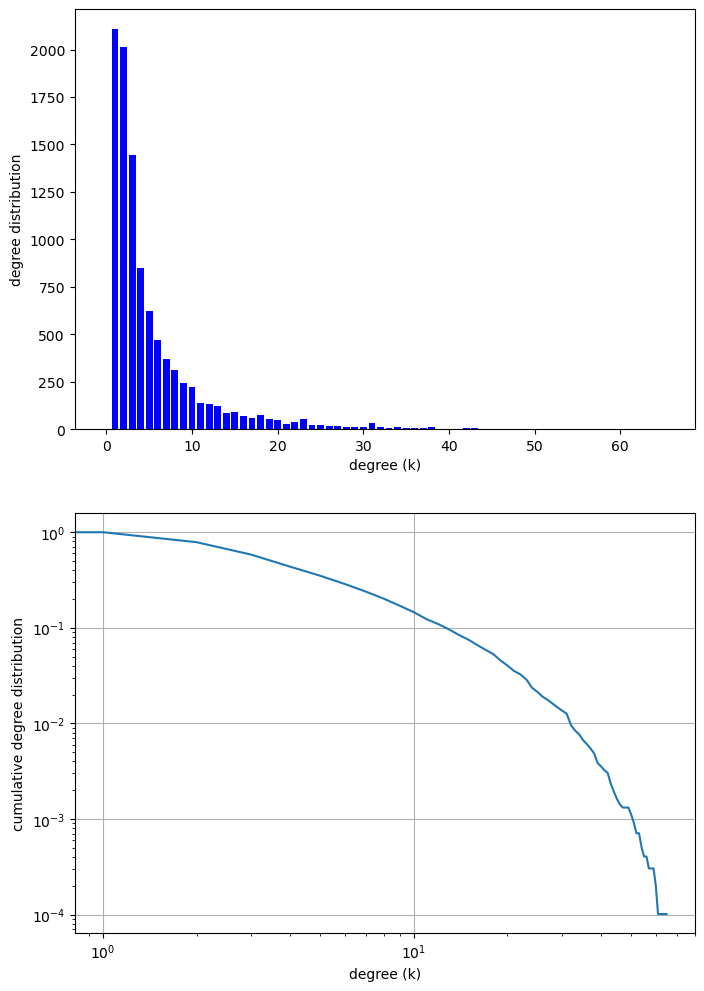

In [373]:
G_real = nx.read_weighted_edgelist('ca-HepTh.edgelist')       # read in real network
MG_rand = nx.configuration_model(degree_sequence(G_real))     # create random network based on degree sequence
G_rand = nx.Graph()                                           # initialize non-nultigraph so that clustering can be calculated
for n, nbrs in G_real.adjacency():                            # loop over adjacency matrix
    for nbr, edict in nbrs.items():                           # loop over the multi-edges
        sumvalue = sum([d['weight'] for d in edict.values()]) # add weights of all edges between common nodes
        G_rand.add_edge(n, nbr, weight = sumvalue)            # add edge of weight that is sum of multi-edges
n = MG_rand.number_of_nodes()                                 # find num nodes (n)
m = MG_rand.number_of_edges()                                 # find num edges (m)
avg_clustering = nx.average_clustering(G_rand)                # find average clustering
print('Duplication Divergence Graph:')                        # label graph
print('\tn: %i' % n)                                          # output num nodes (n)
print('\tm: %i' % m)                                          # output num edges (m)
print('\taverage clustering: %1.4f' % avg_clustering)         # output average clustering
calc_powerlaw(MG_rand,50,cut_graphs=False)                    # calculate power law
plt.show()                                                    # show plots

## Section 13.2 - 13.4: Configuration Model

### compute te average degree of the network and compare it to the average degree of the neighbor nodes

In [374]:
def friendship_paradox(G):
    n = nx.number_of_nodes(G)                                      # find number of nodes
    m = nx.number_of_edges(G)                                      # find number of edges
    c = 2 * m / n                                                  # calculate average degree
    print('\taverage degree c = %1.4f' % c)                        # output average degree c
    neighb_avg_deg = nx.average_neighbor_degree(G,weight='weight') # get list of every node's neighbors average degree
    averages = neighb_avg_deg.values()                             # get values of dict by themselves
    sum = 0                                                        # initialize value of zero
    for value in averages:                                         # loop to add each value
        sum = sum + value                                          # add each value
    avg = sum / len(averages)                                      # calculate average
    print('\taverage degree of neighbor = %1.4f' % avg)            # output average degree of neighbor

G = nx.read_weighted_edgelist('texas_road_sample.edgelist')      # read in texas road sample network
print('texas road sample network:')                              # output current network
friendship_paradox(G)                                            # find and output values
G = nx.read_weighted_edgelist('international_airports.edgelist') # read in international airports network
print('international airports network:')                         # output current network
friendship_paradox(G)                                            # find and output values

texas road sample network:
	average degree c = 2.4986
	average degree of neighbor = 2.9738
international airports network:
	average degree c = 10.6683
	average degree of neighbor = 46.2141


The reason the friendhsip paradox is found much more presently in the international airport network and not in the texas road sample is because in the texas road sample, the nodes are intersections and endpoints, so it is much likely for any of those to be very large hubs, but in the network of international airports, there are likely to be very large hubs that are connected to a very large number of nodes. The prescence of large 'super hubs' is what feeds the friendship paradox, thus it is more present in the network that is expected to have larger hubs.